# Data cleaning of AirBnb

In [1]:
from IPython.display import display_markdown

display_markdown(open("README.md").read(), raw=True)

# AirBnb data

This dataset is based on the 2016-07-07 San Diego extract from Inside Airbnb. The original set includes AirBnb property listings with characteristics and price, and this is extended to additional variables based on each property's location.

- `Source`: Inside AirBnb
- `URL`

> [http://insideairbnb.com/](http://insideairbnb.com/)

- `Processing`: download of the original files and addition of new variables is documented in `regression_cleaning.ipynb`
    - Clean file: `regression_db.geojson`


In [2]:
%matplotlib inline

import requests
import pandas as pd
import geopandas as gpd
#import googlemaps
from scipy.spatial.distance import cdist

## Download files

* Download detailed listings file:

In [3]:
url = 'http://data.insideairbnb.com/united-states/'\
      'ca/san-diego/2016-07-07/data/'\
      'listings.csv.gz'
r = requests.get(url)
with open('listings.csv.gz', 'wb') as fo:
    fo.write(r.content)

* Download calendar file with prices

In [4]:
url = 'http://data.insideairbnb.com/united-states/'\
      'ca/san-diego/2016-07-07/data/'\
      'calendar.csv.gz'
r = requests.get(url)
with open('calendar.csv.gz', 'wb') as fo:
    fo.write(r.content)

* Download neighborhoods

In [5]:
url = 'http://data.insideairbnb.com/united-states/'\
      'ca/san-diego/2016-07-07/visualisations/'\
      'neighbourhoods.geojson'
r = requests.get(url)
with open('neighbourhoods.geojson', 'wb') as fo:
    fo.write(r.content)

## Variable setup

### Parse price

In [6]:
lst = pd.read_csv('listings.csv.gz')
lst['priceN'] = lst['price'].apply(
                    lambda x: float(str(x)\
                                    .replace(',', '')\
                                    .strip('$')))
lst['l_price'] = pd.np.log(lst['priceN'])

### `GeoDataFrame`

In [7]:
from shapely.geometry import Point
xys = lst[['longitude', 'latitude']]\
        .apply(lambda row: Point(*row), axis=1)
gdb = gpd.GeoDataFrame(lst.assign(geometry=xys),
                       crs="+init=epsg:4326")

### Variables

* Pool

In [8]:
ams = []
gdb['pool'] = 0
for i in range(gdb.shape[0]):
    r = gdb.loc[i, 'amenities']
    pcs = r.strip('{').strip('}').split(',')
    ams.extend(pcs)
    if 'Pool' in pcs:
        gdb.loc[i, 'pool'] = 1
set(ams)

{'',
 '"24-Hour Check-in"',
 '"Air Conditioning"',
 '"Buzzer/Wireless Intercom"',
 '"Cable TV"',
 '"Carbon Monoxide Detector"',
 '"Elevator in Building"',
 '"Family/Kid Friendly"',
 '"Fire Extinguisher"',
 '"First Aid Kit"',
 '"Free Parking on Premises"',
 '"Hair Dryer"',
 '"Hot Tub"',
 '"Indoor Fireplace"',
 '"Laptop Friendly Workspace"',
 '"Lock on Bedroom Door"',
 '"Other pet(s)"',
 '"Pets Allowed"',
 '"Pets live on this property"',
 '"Safety Card"',
 '"Smoke Detector"',
 '"Smoking Allowed"',
 '"Suitable for Events"',
 '"Wheelchair Accessible"',
 '"Wireless Internet"',
 '"translation missing: en.hosting_amenity_49"',
 '"translation missing: en.hosting_amenity_50"',
 'Breakfast',
 'Cat(s)',
 'Dog(s)',
 'Doorman',
 'Dryer',
 'Essentials',
 'Gym',
 'Hangers',
 'Heating',
 'Internet',
 'Iron',
 'Kitchen',
 'Pool',
 'Shampoo',
 'TV',
 'Washer'}

* Distance to Balboa park

<iframe width="425" height="350" frameborder="0" scrolling="no" marginheight="0" marginwidth="0" src="http://www.openstreetmap.org/export/embed.html?bbox=-117.16953277587892%2C32.63070127641626%2C-117.12335586547853%2C32.82983681046287&amp;layer=mapnik&amp;marker=32.73030211394726%2C-117.14649954999999" style="border: 1px solid black"></iframe><br/><small><a href="https://www.openstreetmap.org/?mlat=32.7303&amp;mlon=-117.1465#map=13/32.7303/-117.1465">View Larger Map</a></small>

We can use [`geopy`](https://github.com/geopy/geopy) to find out its location:

In [9]:
from geopy.geocoders import Nominatim
geolocator = Nominatim()

Just type the name into the locator:

In [10]:
bp = geolocator.geocode("Balboa Park, San Diego, US")
bp

Location(Balboa Park, North Park, San Diego, San Diego County, California, 92102, United States of America, (32.73135675, -117.146526555704, 0.0))

In [11]:
b_ll = bp.longitude, bp.latitude
b_ll

(-117.146526555704, 32.73135675)

Then calculate distance to the park from each house:

In [12]:
# USA Contiguous Albers Equal Area (m.)
# http://epsg.io/102003
tgt_crs = "+proj=aea +lat_1=29.5 +lat_2=45.5 +lat_0=37.5 "\
          "+lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs"

b_xy = gpd.GeoSeries(Point(b_ll), crs=gdb.crs).to_crs(tgt_crs)[0]
b_xy = (b_xy.x, b_xy.y)
# Calculate distance in Km.
d2b = lambda pt: cdist([(pt.x, pt.y)], [b_xy])[0][0] / 1000

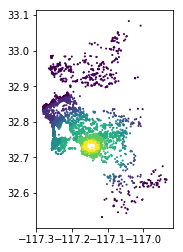

In [13]:
gdb['d2balboa'] = gdb['geometry'].to_crs(tgt_crs)\
                                 .apply(d2b)
gdb.plot(column='d2balboa', scheme='quantiles', k=9,
         cmap='viridis_r', s=1)

* Elevation

In [14]:
key = open('../google_maps_key').readline().strip('\n')
gmaps = googlemaps.Client(key=key)

In [15]:
# Google takes lat/lon instead of lon/lat
gmaps.elevation([b_ll[::-1]])

[{'elevation': 89.00752258300781,
  'location': {'lat': 32.73136, 'lng': -117.14653},
  'resolution': 4.771975994110107}]

In [16]:
pts = gdb['geometry'].apply(lambda pt: (pt.y, pt.x))
%time ele = gmaps.elevation(pts.head().tolist())
ele

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 309 ms


[{'elevation': 95.95661163330078,
  'location': {'lat': 32.58188, 'lng': -117.00194},
  'resolution': 4.771975994110107},
 {'elevation': 171.3590698242188,
  'location': {'lat': 32.65303, 'lng': -116.97681},
  'resolution': 4.771975994110107},
 {'elevation': 177.8932495117188,
  'location': {'lat': 32.66148, 'lng': -116.97181},
  'resolution': 4.771975994110107},
 {'elevation': 184.3952026367188,
  'location': {'lat': 32.63869, 'lng': -116.95125},
  'resolution': 4.771975994110107},
 {'elevation': 185.0911254882812,
  'location': {'lat': 32.63894000000001, 'lng': -116.93889},
  'resolution': 4.771975994110107}]

In [17]:
extract_ele = lambda x: pd.Series(x)['elevation']
eleS = pd.Series(ele).apply(extract_ele)
eleS

0     95.956612
1    171.359070
2    177.893250
3    184.395203
4    185.091125
dtype: float64

* Coastal neighborhood?

**NOTE**: Still some mistakes it seems but `neighborhood_cleansed` works much better than `neighborhood`.

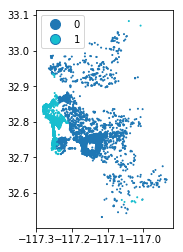

In [18]:
coastal_neighborhoods = ['Wooded Area', 'Ocean Beach', 'Pacific Beach', \
                         'La Jolla', 'Torrey Pines', 'Del Mar Heighs', \
                         'Mission Bay']
def coastal(neigh):
    if neigh in coastal_neighborhoods:
        return 1
    else:
        return 0
gdb['coastal_neig'] = gdb['neighbourhood_cleansed'].apply(coastal)

gdb.plot(column='coastal_neig', s=1,
         categorical=True, legend=True);

* Large neighborhood

We keep only observations in neighborhoods with more than 25 AirBnb houses so FE on neighborhood make sense.

In [19]:
lrg_nei = gdb.groupby('neighbourhood_cleansed').size() > 25
gdb['lrg_nei'] = gdb['neighbourhood_cleansed'].map(lrg_nei)

* List to keep

In [20]:
xs = ['accommodates', 'bathrooms', 'bedrooms', 
      'beds', 'neighbourhood_cleansed', 'pool',
      'd2balboa', 'coastal_neig', 'lrg_nei',
      'priceN', 'l_price',
      'geometry', 'id']

### Dummies

* Room type

In [21]:
rt = pd.get_dummies(gdb['room_type'], prefix='rt').rename(columns=lambda x: x.replace(' ', '_'))

* Property type

In [22]:
def simplify(p):
    bigs = ['House', 'Apartment', 'Condominium', 'Townhouse']
    if p in bigs:
        return p
    else:
        return 'Other'

gdb['property_group'] = gdb['property_type'].apply(simplify)
pg = pd.get_dummies(gdb['property_group'], prefix='pg')

### Write out

In [23]:
gdb[['lrg_nei']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6608 entries, 0 to 6607
Data columns (total 1 columns):
lrg_nei    6608 non-null bool
dtypes: bool(1)
memory usage: 6.5 KB


In [24]:
! rm 'regression_db.geojson'
final = gdb[xs].join(pg)\
               .join(rt)\
               .rename(columns={'priceN': 'price'})\
               .loc[gdb['lrg_nei']==True, :]\
               .drop(['lrg_nei'], axis=1)\
               .dropna()


<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 6110 entries, 19 to 6607
Data columns (total 20 columns):
accommodates              6110 non-null int64
bathrooms                 6110 non-null float64
bedrooms                  6110 non-null float64
beds                      6110 non-null float64
neighbourhood_cleansed    6110 non-null object
pool                      6110 non-null int64
d2balboa                  6110 non-null float64
coastal_neig              6110 non-null int64
price                     6110 non-null float64
l_price                   6110 non-null float64
geometry                  6110 non-null object
id                        6110 non-null int64
pg_Apartment              6110 non-null uint8
pg_Condominium            6110 non-null uint8
pg_House                  6110 non-null uint8
pg_Other                  6110 non-null uint8
pg_Townhouse              6110 non-null uint8
rt_Entire_home/apt        6110 non-null uint8
rt_Private_room           6110 non-null ui

In [7]:
final = final.rename(columns=dict(neighbourhood_cleansed='neighborhood', 
                          coastal_neig='coastal',
                          l_price = 'log_price'))

In [12]:
!rm regression_db.geojson
final.to_file('regression_db.geojson', driver='GeoJSON')
final.info()

rm: cannot remove 'airbnb/regression_db.geojson': No such file or directory
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 6110 entries, 0 to 6109
Data columns (total 20 columns):
accommodates          6110 non-null int64
bathrooms             6110 non-null float64
bedrooms              6110 non-null float64
beds                  6110 non-null float64
neighborhood          6110 non-null object
pool                  6110 non-null int64
d2balboa              6110 non-null float64
coastal               6110 non-null int64
price                 6110 non-null float64
log_price             6110 non-null float64
id                    6110 non-null int64
pg_Apartment          6110 non-null int64
pg_Condominium        6110 non-null int64
pg_House              6110 non-null int64
pg_Other              6110 non-null int64
pg_Townhouse          6110 non-null int64
rt_Entire_home/apt    6110 non-null int64
rt_Private_room       6110 non-null int64
rt_Shared_room        6110 non-null int6

---

[[Download the `regression_db.geojson` file]](regression_db.geojson)